# Лабораторная работа №1 по дисциплине "Системы обработки больших данных"
## Подключаем библиотеки и датасет. Определяем колонки по типу, выводим их, а также выполняем вывод части данных

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
MAX_MEMORY = '4G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = "data/itineraries.csv"
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data, sep=",", inferSchema=True, header=True)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


### Выполняем разведочный анализ датасета с определением:

In [3]:
spark

In [4]:
print (pd.__version__)

1.5.3


#### 1. Типы признаков в датасете:

In [5]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDeparture

,Column Name,Data type
0,legId,string
1,searchDate,date
2,flightDate,date
3,startingAirport,string
4,destinationAirport,string
5,fareBasisCode,string
6,travelDuration,string
7,elapsedDays,int
8,isBasicEconomy,boolean
9,isRefundable,boolean


In [6]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,baseFare,totalFare,seatsRemaining,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,count,349998,349998,349998,349998,349998,349998,349998,349998,349998,...,349998,349998,349998,349998,349998,349998,343746,349998,349998,349998
1,mean,None,None,None,None,None,0.14509225767004383,297.8273932136842,345.46070308966205,5.253810021771553,...,1.6513306244496546E9,None,None,None,None,None,None,11006.445965800744,1092.9465653755617,None
2,stddev,None,None,None,None,None,0.3521943339105614,214.53493612880322,230.6054240892679,2.974461217284122,...,755817.1860520752,None,None,None,None,None,None,5187.44788192041,722.8970738084727,None
3,min,000012c2ee248f2294bdfe0cf464cde6,ATL,ATL,A0ATZNFC,P1DT12M,0,5.1,23.97,0,...,1650186900,2022-04-17T04:29:00.000-06:00,ABE||ATL,ATL,Alaska Airlines,4B||4B||AA,AIRBUS INDUSTRIE A320 SHARKLETS,10020,1007||207,business
4,max,ffffca09ae8365ab94eb2837fda23dcb,SFO,SFO,ZVAUZON3,PT9H9M,1,3531.16,3810.6,10,...,1652859360||1652884440,2022-05-18T01:01:00.000-04:00||2022-05-18T10:4...,XNA||ORD,TTN||RDU,United||United||United||United,UA||UA||UA||UA,||||Embraer 175,9960||9960,None||None||None,premium coach||premium coach||coach


There are total 349998 row, Let print first 2 data rows:


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach


#### 2. Выявление пропущенных значений и их устранение:
##### Определяем пропущенные значения:

In [7]:
string_columns = ['legId', 'startingAirport', 'destinationAirport','fareBasisCode','travelDuration','segmentsDepartureTimeEpochSeconds','segmentsDepartureTimeRaw','segmentsArrivalTimeEpochSeconds','segmentsArrivalTimeRaw']
numeric_columns = ['elapsedDays','seatsRemaining','totalTravelDistance','baseFare','totalFare']
binary_columns = ['isBasicEconomy','isRefundable','isNonStop']

def view_missing_values(string_columns,numeric_columns,binary_columns):
    missing_values = {} 
    for index, column in enumerate(df.columns):
        if column in string_columns:    # check string columns with None and Null values
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
            missing_values.update({column:missing_count})
        if column in numeric_columns:  # check zeroes, None, NaN
            missing_count = df.where(col(column).isin([None,np.nan])).count()
            missing_values.update({column:missing_count})
        if column in binary_columns:  # check zeroes, None, NaN
            missing_count = df.where(col(column).isNull()).count()
            missing_values.update({column:missing_count})
    return pd.DataFrame.from_dict([missing_values])
missing_df = view_missing_values(string_columns,numeric_columns,binary_columns)
missing_df

,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Осуществляем удаление найденных пропущенных значений:

In [8]:
df = df.dropna() # удаление пропущенных значений

In [9]:
missing_df = view_missing_values(string_columns,numeric_columns,binary_columns)
missing_df

,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 3. Определение выбросов и их устранение:

<Axes: >

Text(0.5, 1.0, 'Boxplot of elapsedDays')

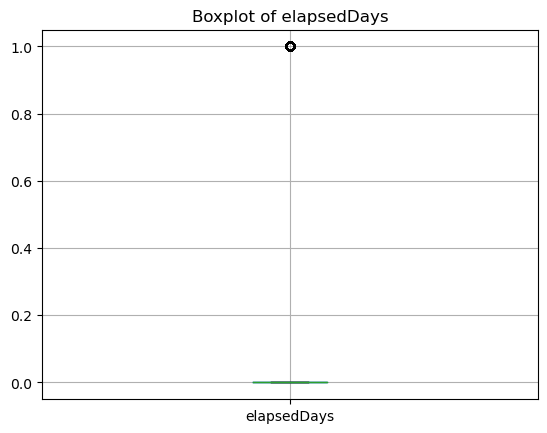

<Axes: >

Text(0.5, 1.0, 'Boxplot of seatsRemaining')

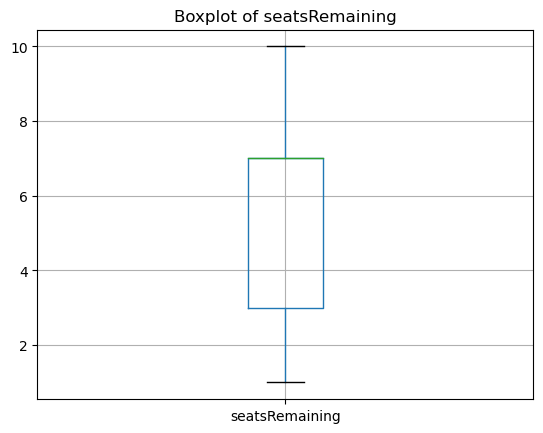

<Axes: >

Text(0.5, 1.0, 'Boxplot of totalTravelDistance')

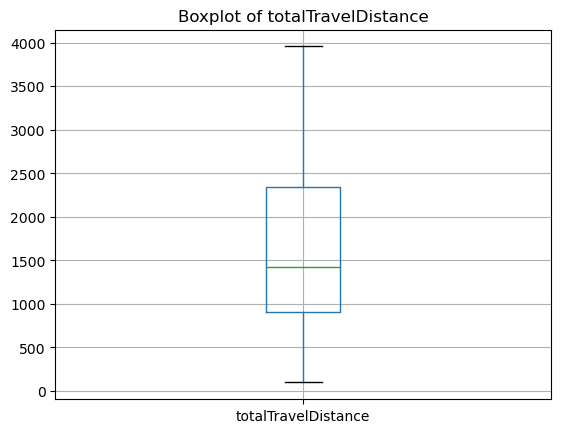

<Axes: >

Text(0.5, 1.0, 'Boxplot of baseFare')

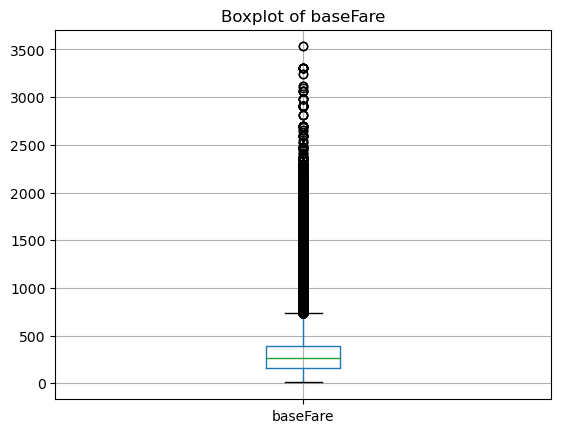

<Axes: >

Text(0.5, 1.0, 'Boxplot of totalFare')

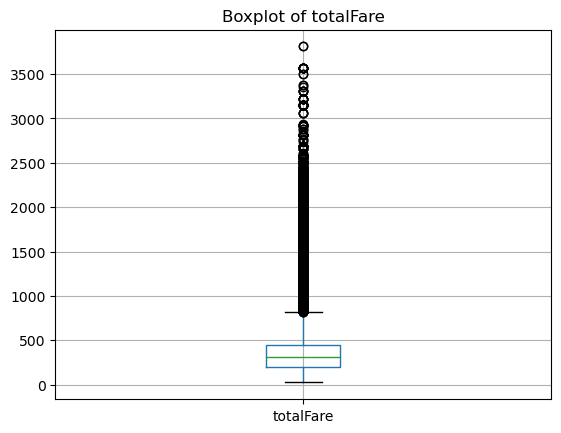

In [10]:
pandas_df = df.toPandas()
for column in numeric_columns:
    pandas_df.boxplot(column)
    plt.title(f'Boxplot of {column}')
    plt.show()

In [11]:
#Метод межквартильного диапазона
for column in numeric_columns:
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))



df.select(numeric_columns).describe().show()

+-------+-----------+-----------------+-------------------+------------------+------------------+
|summary|elapsedDays|   seatsRemaining|totalTravelDistance|          baseFare|         totalFare|
+-------+-----------+-----------------+-------------------+------------------+------------------+
|  count|     270345|           270345|             270345|            270345|            270345|
|   mean|        0.0|5.592568754739315| 1468.4398934694557|270.92176862897975| 312.7127613604665|
| stddev|        0.0|2.748972948580033|  783.2296385744369| 140.0261533749845|152.41496235300468|
|    min|          0|                1|                 97|              8.72|             23.97|
|    max|          0|               10|               3842|            664.19|            733.61|
+-------+-----------+-----------------+-------------------+------------------+------------------+



<Axes: >

Text(0.5, 1.0, 'Boxplot of elapsedDays')

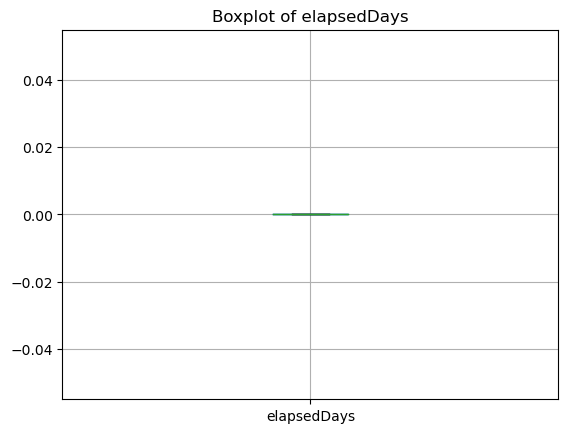

<Axes: >

Text(0.5, 1.0, 'Boxplot of seatsRemaining')

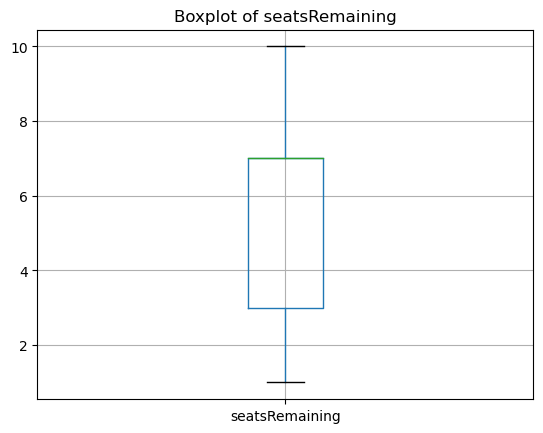

<Axes: >

Text(0.5, 1.0, 'Boxplot of totalTravelDistance')

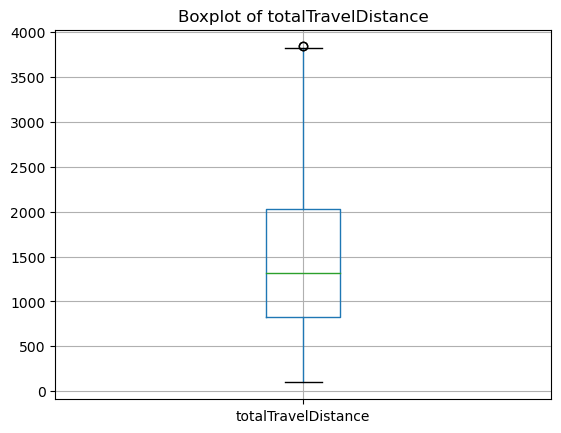

<Axes: >

Text(0.5, 1.0, 'Boxplot of baseFare')

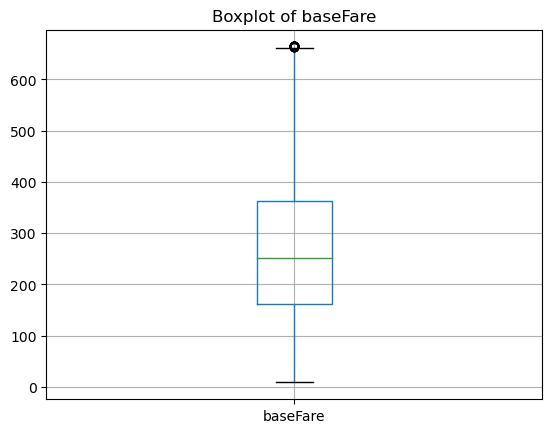

<Axes: >

Text(0.5, 1.0, 'Boxplot of totalFare')

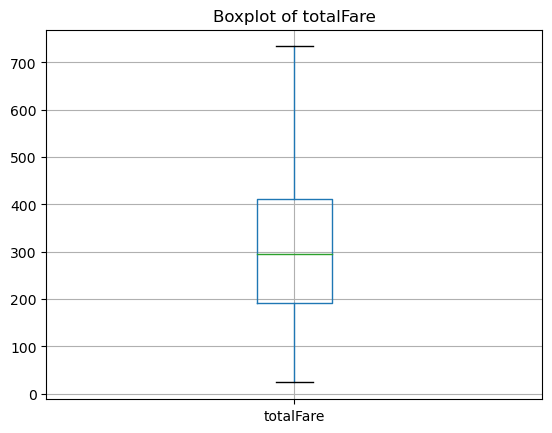

In [12]:
pandas_df = df.toPandas()
for column in numeric_columns:
    pandas_df.boxplot(column)
    plt.title(f'Boxplot of {column}')
    plt.show()

#### 4. Расчет статистических показателей признаков (средних, квартилей и т.д.):

#### Общая статистика:

In [13]:
# Количество записей отличных от Nan значений
# Среднее
# Стандартное отклонение
# минимум
# процентили
# максимум
df[numeric_columns].summary().show()

+-------+-----------+-----------------+-------------------+------------------+------------------+
|summary|elapsedDays|   seatsRemaining|totalTravelDistance|          baseFare|         totalFare|
+-------+-----------+-----------------+-------------------+------------------+------------------+
|  count|     270345|           270345|             270345|            270345|            270345|
|   mean|        0.0|5.592568754739315| 1468.4398934694557|270.92176862897975| 312.7127613604665|
| stddev|        0.0|2.748972948580033|  783.2296385744369| 140.0261533749845|152.41496235300468|
|    min|          0|                1|                 97|              8.72|             23.97|
|    25%|          0|                3|                829|            161.86|             191.6|
|    50%|          0|                7|               1321|            252.09|             294.6|
|    75%|          0|                7|               2030|            361.86|             411.6|
|    max|          0

In [14]:
# Количество записей
# Количество уникальных значений
# Наибольшее количество
# Частота наиболее распространённого значения
df[string_columns].describe().show()

+-------+--------------------+---------------+------------------+-------------+--------------+---------------------------------+------------------------+-------------------------------+----------------------+
|summary|               legId|startingAirport|destinationAirport|fareBasisCode|travelDuration|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|
+-------+--------------------+---------------+------------------+-------------+--------------+---------------------------------+------------------------+-------------------------------+----------------------+
|  count|              270345|         270345|            270345|       270345|        270345|                           270345|                  270345|                         270345|                270345|
|   mean|                null|           null|              null|         null|          null|              1.651327478734595E9|                    null|           

In [15]:
# Количество записей
# Количество уникальных значений
# Наибольшее количество
# Частота наиболее распространённого значения
pandas_df[binary_columns].describe()

,isBasicEconomy,isRefundable,isNonStop
count,270345,270345,270345
unique,2,2,2
top,False,False,False
freq,244724,270341,188553


#### Статистика распределения длины пути по начальному аэропорту

In [16]:
statistic = (df
            .groupby("startingAirport")
            .agg(functions.count('totalTravelDistance').alias('count'),
                 functions.mean('totalTravelDistance').alias('mean'),
                 functions.stddev('totalTravelDistance').alias('std'),
                 functions.min('totalTravelDistance').alias('min'),
                 functions.expr('percentile(totalTravelDistance, array(0.25))')[0].alias('%25'),
                 functions.expr('percentile(totalTravelDistance, array(0.5))')[0].alias('%50'),
                 functions.expr('percentile(totalTravelDistance, array(0.75))')[0].alias('%75'),
                 functions.max('totalTravelDistance').alias('max'))).show()

+---------------+-----+------------------+-----------------+---+------+------+-------+----+
|startingAirport|count|              mean|              std|min|   %25|   %50|    %75| max|
+---------------+-----+------------------+-----------------+---+------+------+-------+----+
|            OAK| 6048|2041.3959986772486|790.2744035917178|338|1380.0|2083.0| 2679.0|3691|
|            LGA|23752|1401.4405944762545|861.5931548722439|185| 720.0|1144.0| 2105.0|3686|
|            BOS|22415|1358.4339504795896|878.4015430378436|121| 728.0|1260.0| 1815.0|3842|
|            EWR|14663|1424.8510536725091|794.2691577372003| 97| 762.0|1358.0| 2030.0|3665|
|            DEN|15048|1543.0788809144071|450.1794627759916|590|1186.0|1622.0| 1834.0|2976|
|            IAD|12423|1321.9205505916445|804.8466079668689|221| 756.0|1024.0| 1842.0|3363|
|            CLT|20953|1239.5040328353934| 757.761243740872|228| 652.0| 990.0| 1649.0|3426|
|            MIA|17186|1594.0296753171185|705.7148613387961|596|1115.0|1314.0| 1

#### Процентное отношение значений bool и их количество

In [17]:
isBasicEconomy_df = df.groupBy('isBasicEconomy').count()
all_count = df.count()
percentage_isBasicEconomy_df = isBasicEconomy_df.withColumn('percentage',isBasicEconomy_df[1] / all_count *100)
percentage_isBasicEconomy_df.show()

isBasicEconomy_df = df.groupBy('isRefundable').count()
all_count = df.count()
percentage_isBasicEconomy_df = isBasicEconomy_df.withColumn('percentage',isBasicEconomy_df[1] / all_count *100)
percentage_isBasicEconomy_df.show()

isBasicEconomy_df = df.groupBy('isNonStop').count()
all_count = df.count()
percentage_isBasicEconomy_df = isBasicEconomy_df.withColumn('percentage',isBasicEconomy_df[1] / all_count *100)
percentage_isBasicEconomy_df.show()

+--------------+------+-----------------+
|isBasicEconomy| count|       percentage|
+--------------+------+-----------------+
|          true| 25621|9.477149568144409|
|         false|244724| 90.5228504318556|
+--------------+------+-----------------+

+------------+------+--------------------+
|isRefundable| count|          percentage|
+------------+------+--------------------+
|        true|     4|0.001479590893118...|
|       false|270341|   99.99852040910689|
+------------+------+--------------------+

+---------+------+------------------+
|isNonStop| count|        percentage|
+---------+------+------------------+
|     true| 81792|30.254674582477946|
|    false|188553| 69.74532541752205|
+---------+------+------------------+



#### 5. Визуализация распределения наиболее важных признаков:

#### Частота выбора аэропорта для отправления людьми

In [18]:
ranked_destinationAirport_users_df = df.select(df.destinationAirport, df.legId) \
    .distinct() \
    .groupBy(df.destinationAirport) \
    .count() \
    .orderBy("count", ascending=False)
highest_destinationAirport_df = ranked_destinationAirport_users_df.toPandas()
highest_destinationAirport_df.rename(columns = {'count':'Users count'}, inplace = True)
#Общее количество пользователей аэропорта
total_Airport_users= ranked_destinationAirport_users_df.groupBy().sum().collect()[0][0]

In [19]:
ranked_destinationAirport_users_df.collect()

[Row(destinationAirport='LAX', count=20798),
 Row(destinationAirport='LGA', count=17196),
 Row(destinationAirport='DFW', count=15652),
 Row(destinationAirport='ORD', count=14909),
 Row(destinationAirport='SFO', count=14665),
 Row(destinationAirport='MIA', count=14480),
 Row(destinationAirport='DEN', count=14438),
 Row(destinationAirport='CLT', count=14241),
 Row(destinationAirport='ATL', count=13637),
 Row(destinationAirport='BOS', count=13636),
 Row(destinationAirport='DTW', count=11264),
 Row(destinationAirport='JFK', count=10451),
 Row(destinationAirport='EWR', count=9811),
 Row(destinationAirport='PHL', count=9733),
 Row(destinationAirport='IAD', count=8309),
 Row(destinationAirport='OAK', count=7654)]

Топ аэропортов назначения по количество посещающих пользователей:


/tmp/ipykernel_22688/769771783.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highest_destinationAirport_df_renamed = highest_destinationAirport_df_renamed.append(


,destinationAirport,Users count,percentage
0,LAX,20798,9.862762e+00
1,LGA,17196,8.154633e+00
2,DFW,15652,7.422442e+00
3,ORD,14909,7.070099e+00
4,SFO,14665,6.954390e+00
5,MIA,14480,6.866660e+00
6,DEN,14438,6.846743e+00
7,CLT,14241,6.753322e+00
8,ATL,13637,6.466895e+00
9,BOS,13636,6.466421e+00


/tmp/ipykernel_22688/769771783.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_destinationAirport_df_renamed['destinationAirport']


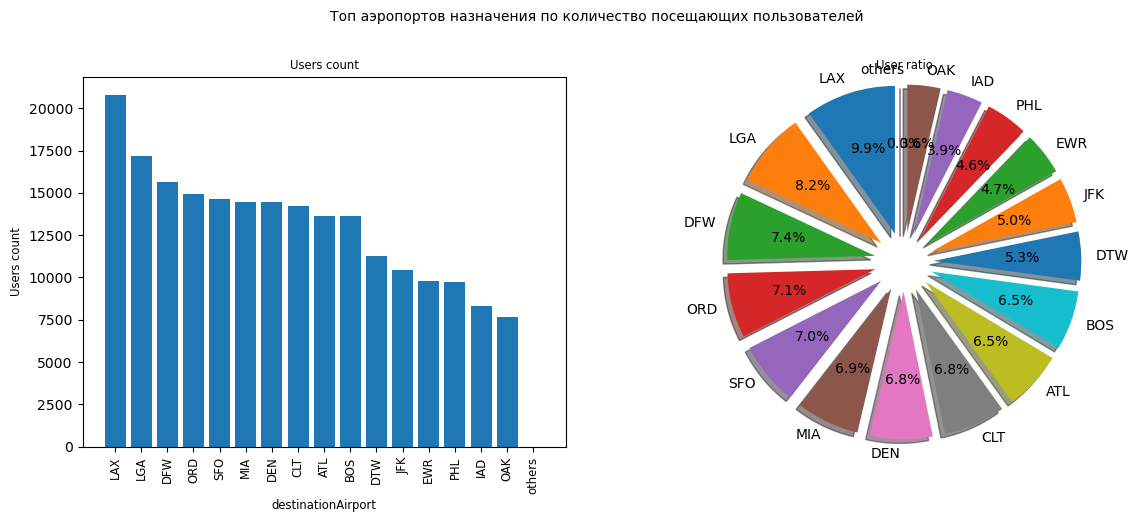

In [20]:
highest_destinationAirport_df_renamed = highest_destinationAirport_df
# Compute the percentage of top 5 workout type / total users
highest_destinationAirport_df_renamed['percentage'] = highest_destinationAirport_df['Users count'] \
    / total_Airport_users * 100

# We assign the rest of users belong to another specific group that we call 'others'
others = {
      'destinationAirport': 'others'
    , 'Users count': total_Airport_users - sum(highest_destinationAirport_df_renamed['Users count'])
    , 'percentage': 100 - sum(highest_destinationAirport_df_renamed['percentage'])
}

highest_destinationAirport_df_renamed = highest_destinationAirport_df_renamed.append(
    others, ignore_index=True
)
print('Топ аэропортов назначения по количество посещающих пользователей:')
highest_destinationAirport_df_renamed

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_destinationAirport_df_renamed['destinationAirport']
                     , height=highest_destinationAirport_df_renamed['Users count'])
title0 =  axs[0].set_title('Users count', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('destinationAirport', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Users count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_destinationAirport_df_renamed['destinationAirport'] 
                                       ,rotation = 'vertical', fontsize='small')
explode = (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2)
title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(
      x=highest_destinationAirport_df_renamed['percentage']
    , labels=highest_destinationAirport_df_renamed['destinationAirport']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
)

text = fig.text(0.5, 1.02, 'Топ аэропортов назначения по количество посещающих пользователей', ha='center', va='top', transform=fig.transFigure)

В сумме: 16 аэропортов, их распределение по другим аэропортам :


/tmp/ipykernel_22688/2869863615.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  plot = activities_by_gender.groupby(['startingAirport', 'destinationAirport']).agg(np.mean).groupby(level=0).apply(


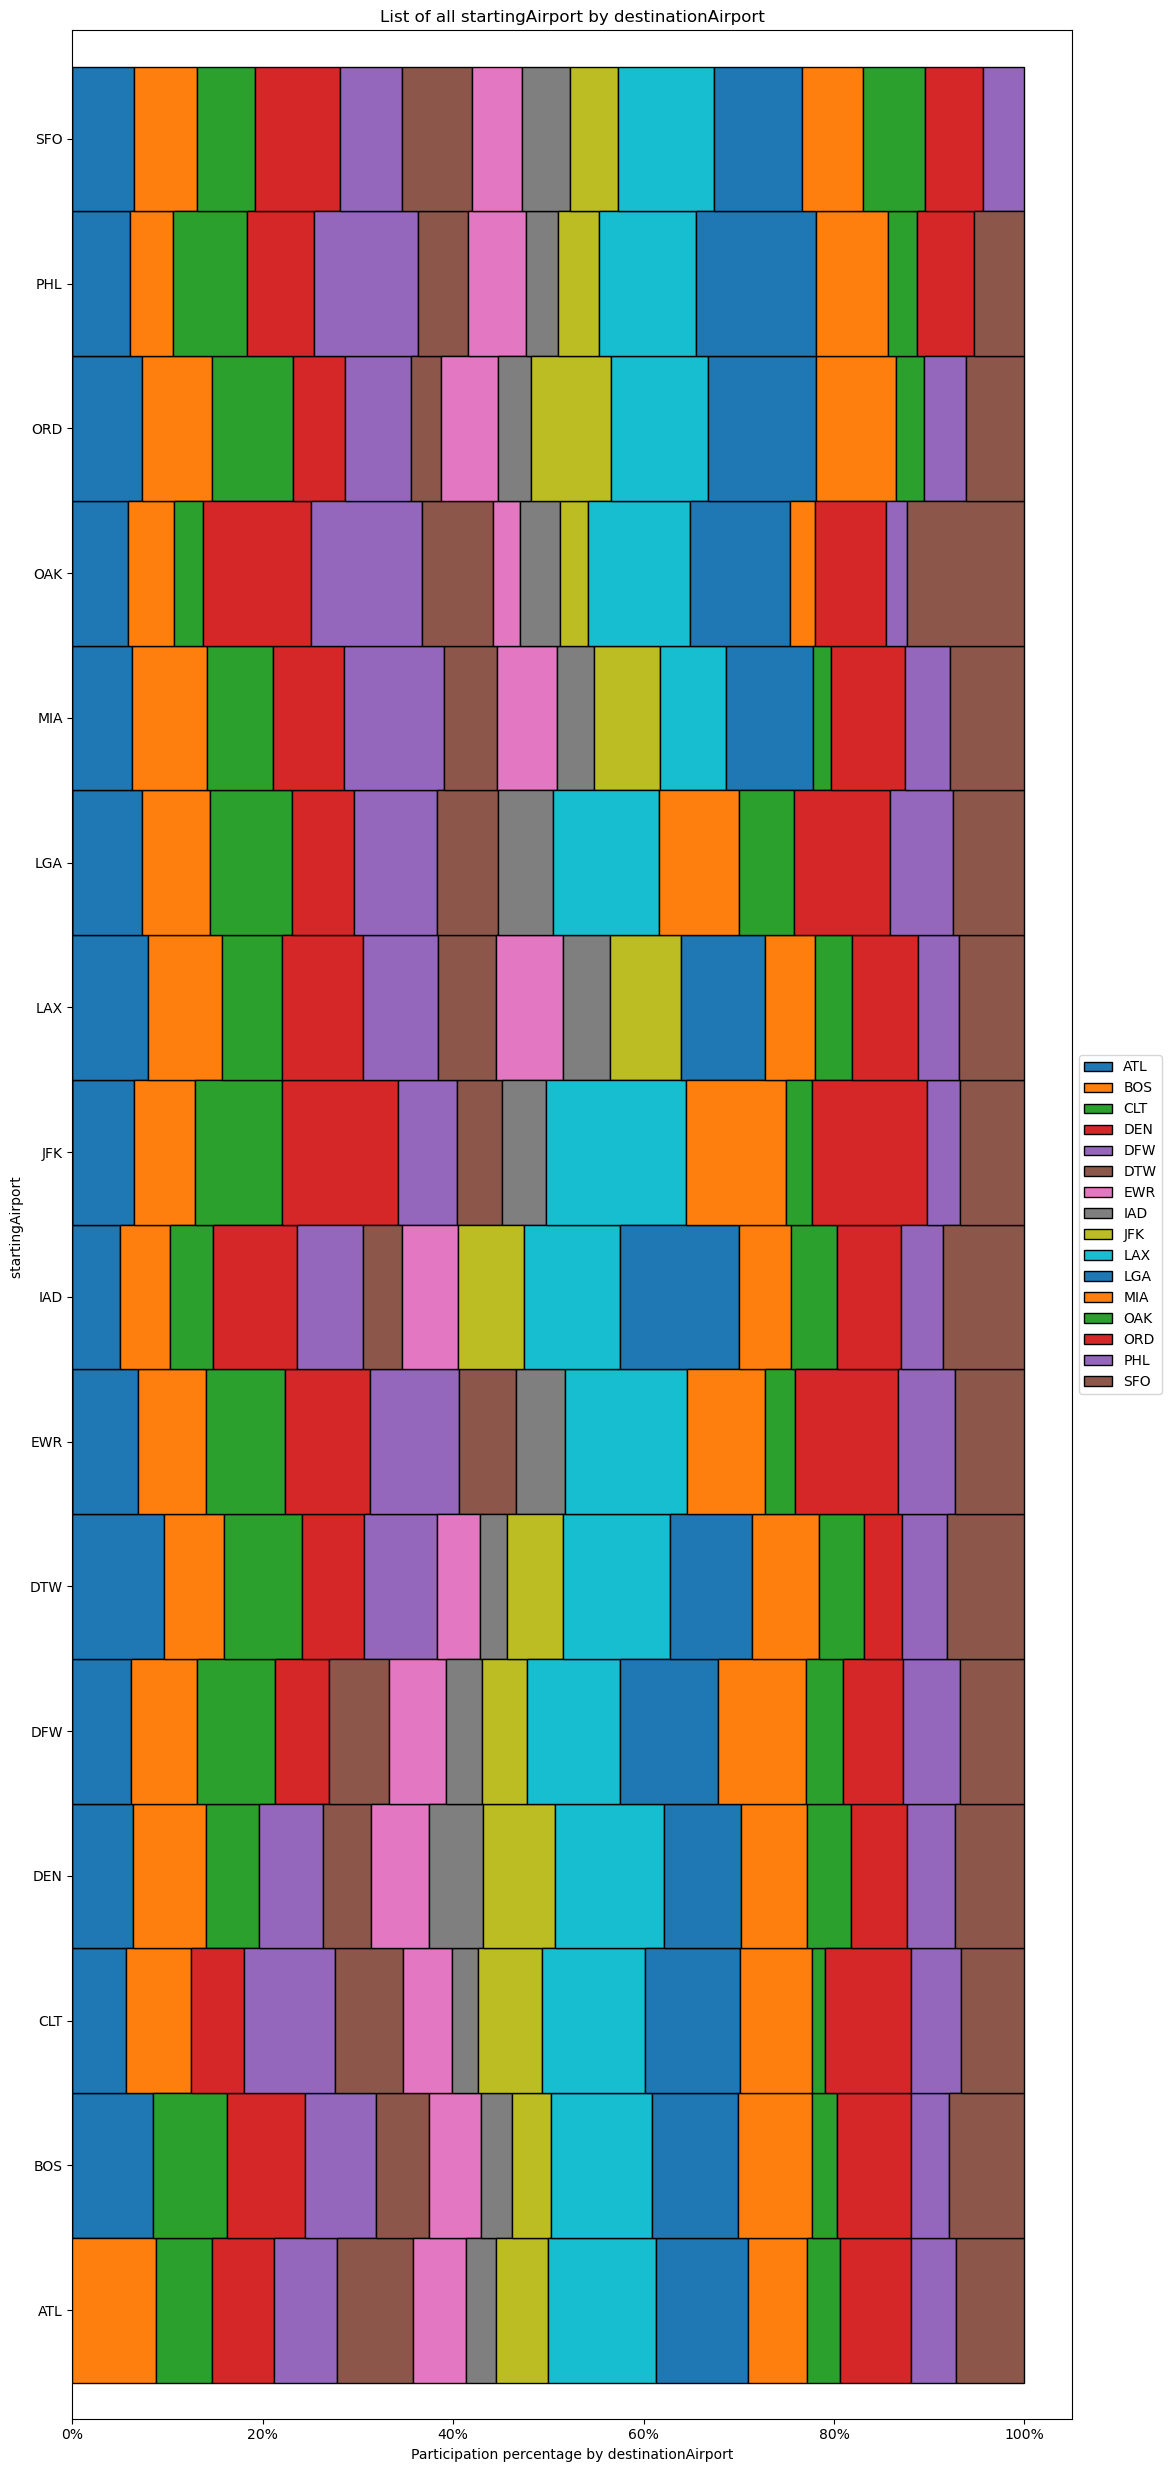

In [21]:
total_Airports = ranked_destinationAirport_users_df.count()
print(f'В сумме: {total_Airports} аэропортов, их распределение по другим аэропортам :')
# Add the infor of activities based on gender
activities_by_gender = df.groupBy('startingAirport', 'destinationAirport').count().toPandas()
# Visualize
fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = activities_by_gender.groupby(['startingAirport', 'destinationAirport']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1  ## APPLY UNSTACK TO RESHAPE DATA
                , edgecolor='black', ax=ax, title='List of all startingAirport by destinationAirport')
ylabel = plt.ylabel('startingAirport ');
xlabel = plt.xlabel('Participation percentage by destinationAirport');
legend = plt.legend(
    sorted(activities_by_gender['destinationAirport'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

/tmp/ipykernel_22688/721585273.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  record= df.select('totalFare', 'destinationAirport').toPandas().hist(


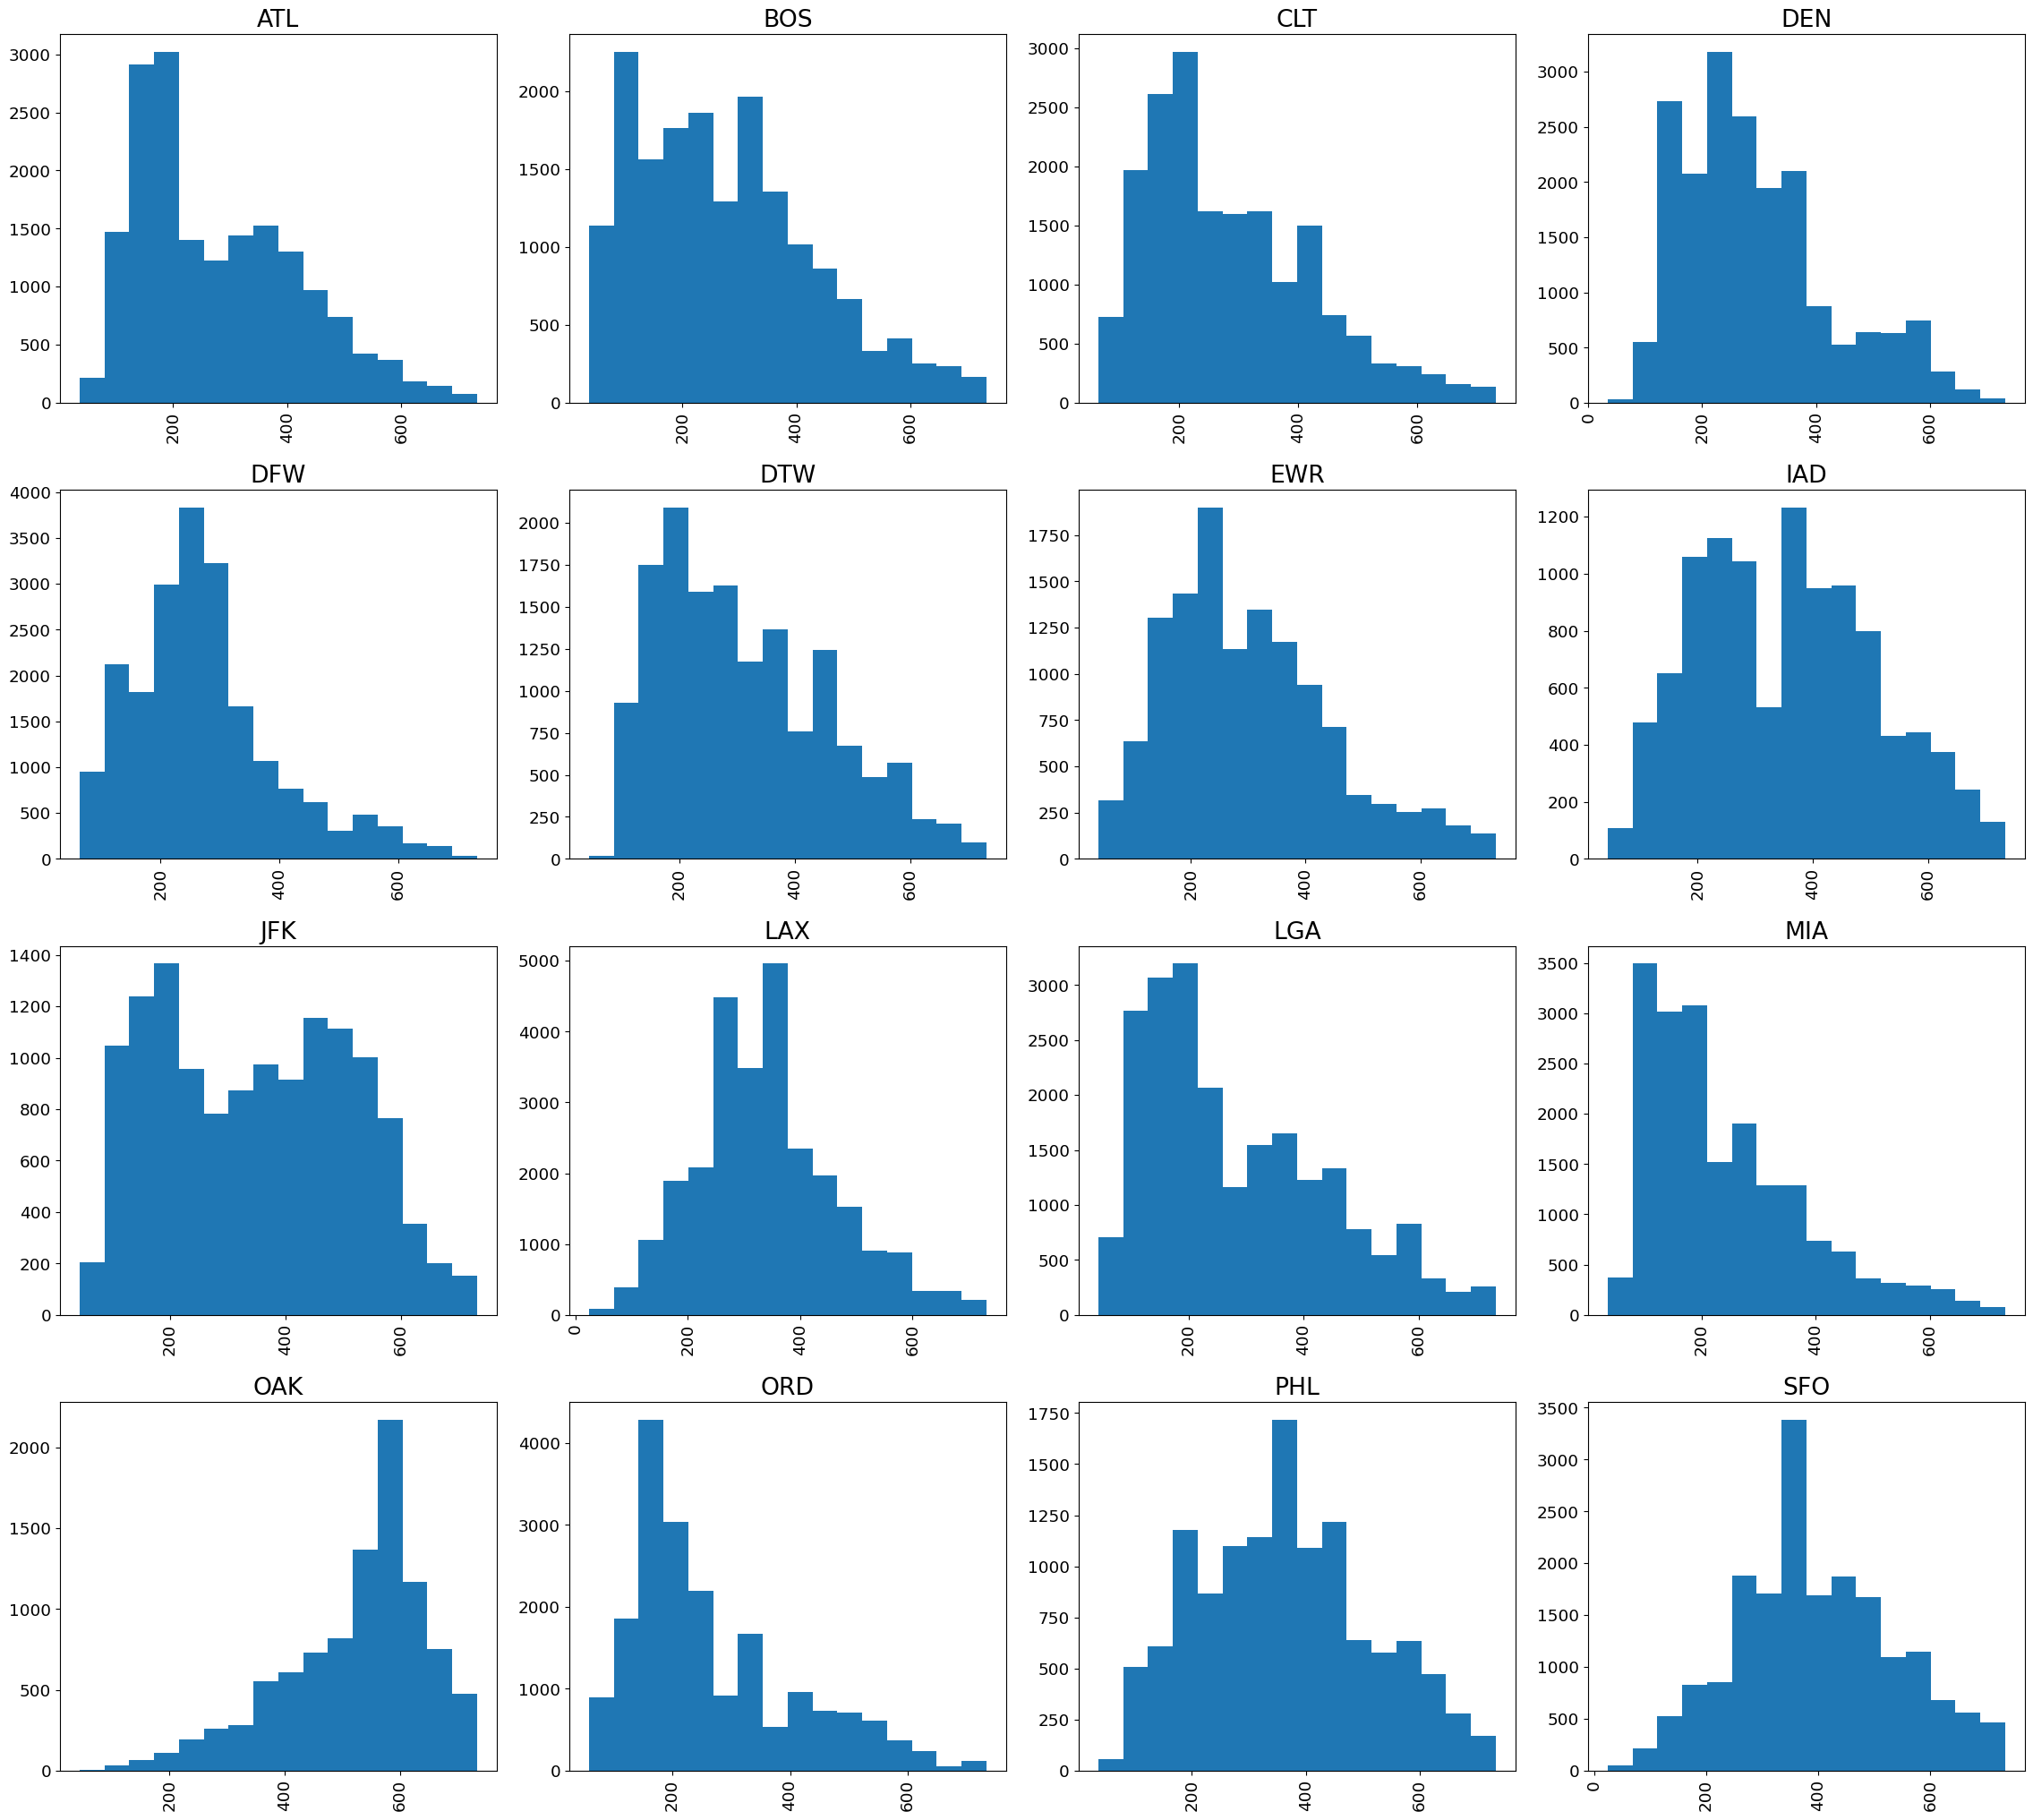

In [22]:
#Распределение количества записей к суммарной дистанции распределённой по аэропортам
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

record= df.select('totalFare', 'destinationAirport').toPandas().hist(
    column='totalFare', bins=16, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small', by='destinationAirport', ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()

#### 6. Корреляции между признаками:
#### Корреляцию можно высчитать только у количественных признаков

In [23]:
print('Data overview')
df.printSchema()

Data overview
root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDeparture

In [24]:
columns = ['seatsRemaining','totalTravelDistance','baseFare','totalFare']
# df.corr("baseFare","totalFare")
vector_col = "corr-column"
assembler = VectorAssembler(inputCols=columns,outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

matrix = Correlation.corr(df_vector,vector_col).collect()[0][0]
corrMatrix = matrix.toArray().tolist()
df_corr = spark.createDataFrame(corrMatrix,columns)
df_corr.show()

+--------------------+--------------------+--------------------+--------------------+
|      seatsRemaining| totalTravelDistance|            baseFare|           totalFare|
+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-0.08210092283943435|-0.16742290537354382|-0.17033849151887484|
|-0.08210092283943435|                 1.0| 0.44842598272380363|  0.4562276498174923|
|-0.16742290537354382| 0.44842598272380363|                 1.0|  0.9995116175556622|
|-0.17033849151887484|  0.4562276498174923|  0.9995116175556622|                 1.0|
+--------------------+--------------------+--------------------+--------------------+



In [32]:
df.coalesce(1).write.option("header", "true").csv("../work/data/lab1_new_df.csv")

##### В ходе лабораторной работы был изучен функционал Apache PySpark. Я научился пользоваться функционалом Apache Spark. Целью работы было познакомиться с понятием "большие данные" провести разведочный анализ датасета. В ходе работы были выполнены пункты:
1. Определены типы признаков в датасете
2. Определены пропущенные значения, которые были устранены
3. Определены выбросы, с их последующим устранением
4. Были рассчитаны статистические показатели признаков (средние, квартили и т.д.)
5. Были визуализированы распределения наиболее важных признаков
6. Была проведена корреляция между всеми числовыми признаками